# Project 5: Vehicle Detection & Tracking

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Project Dependencies

In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.ndimage.measurements import label
from sklearn import svm

from moviepy.editor import *
from IPython.display import HTML

## Load Test Images

In [2]:
def load_test_images():
    images = []
    for path in glob.glob('test_images/*.jpg'):
        img = mpimg.imread(path)
        images.append(img)
    
    return images

test_images = load_test_images()

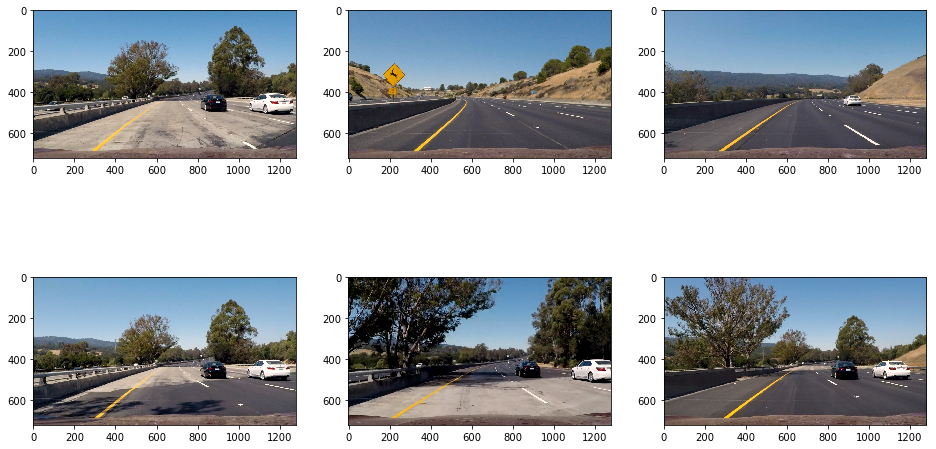

In [3]:
def plot_grid(images):
    fig = plt.figure(figsize=(16,9))
    
    columns = 3
    rows = round(len(images)/columns)
    
    for index, img in enumerate(images):
        a = fig.add_subplot(rows,columns,index+1)
        plt.imshow(img)
    plt.show()
        
plot_grid(test_images)

# Explore Color Spaces

In [4]:
def convert_color(image, conv='RGB'):
    """Convenience method for converting between various color spaces."""
    
    img = np.copy(image)
    
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else:
        # Retain RGB image
        return img

In [5]:
color_spaces = ['RGB', 'RGB2YCrCb', 'RGB2HSV', 'RGB2LUV', 'RGB2HLS', 'RGB2YUV']        

### 3D Color Space Visualization

In [6]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(4, 4))

    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = mpimg.imread("test_images/test6.jpg")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_rgb = img_small / 255.  # scaled to [0, 1], only for plotting

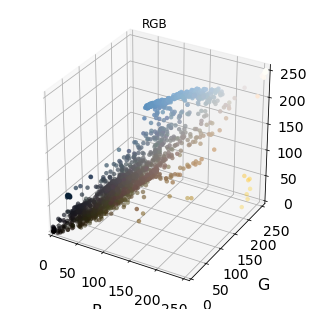

In [7]:
# Plot and show
plot3d(img_small, img_small_rgb)
plt.title('RGB')
plt.show()

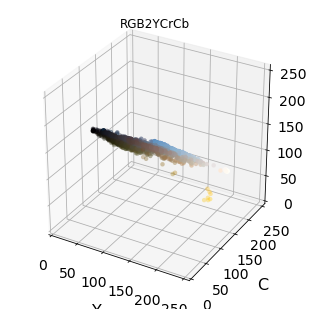

In [8]:
plot3d(convert_color(img_small, color_spaces[1]), img_small_rgb, axis_labels=list("YCC"))
plt.title(color_spaces[1])
plt.show()

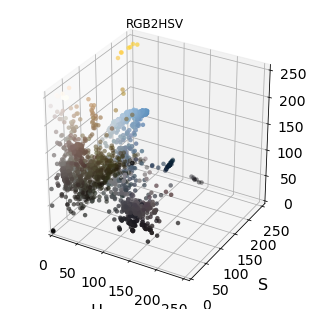

In [9]:
plot3d(convert_color(img_small, color_spaces[2]), img_small_rgb, axis_labels=list("HSV"))
plt.title(color_spaces[2])
plt.show()

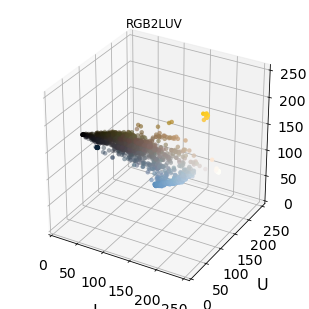

In [10]:
plot3d(convert_color(img_small, color_spaces[3]), img_small_rgb, axis_labels=list("LUV"))
plt.title(color_spaces[3])
plt.show()

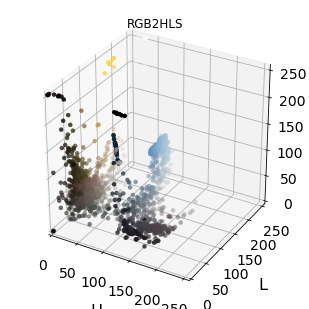

In [11]:
plot3d(convert_color(img_small, color_spaces[4]), img_small_rgb, axis_labels=list("HLS"))
plt.title(color_spaces[4])
plt.show()

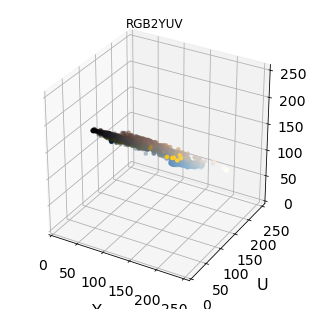

In [12]:
plot3d(convert_color(img_small, color_spaces[5]), img_small_rgb, axis_labels=list("YUV"))
plt.title(color_spaces[5])
plt.show()

### Histograms of Color

In [13]:
def get_histograms(image, color_spaces, bins=32):
    histograms = []
    
    for space in color_spaces:
        img = convert_color(np.copy(image), space)
        
        # Compute the histogram of the RGB channels separately
        ch1_hist = np.histogram(img[:,:,0], bins=bins)
        ch2_hist = np.histogram(img[:,:,1], bins=bins)
        ch3_hist = np.histogram(img[:,:,2], bins=bins)
        
        # Generating bin centers
        bin_edges = ch1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2 

        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
        
        # Return the individual histograms, bin_centers and feature vector
        histogram = ch1_hist, ch2_hist, ch3_hist, bin_centers, hist_features
        histograms.append(histogram)
        
    return histograms

test_histograms = get_histograms(test_images[4], color_spaces, 8)

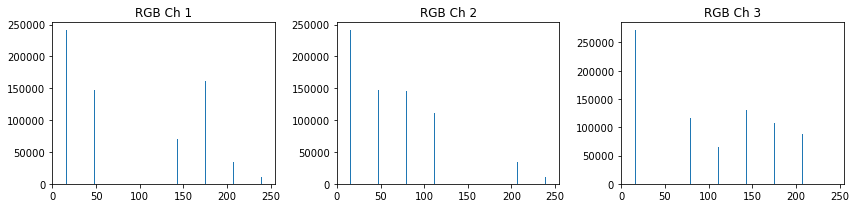

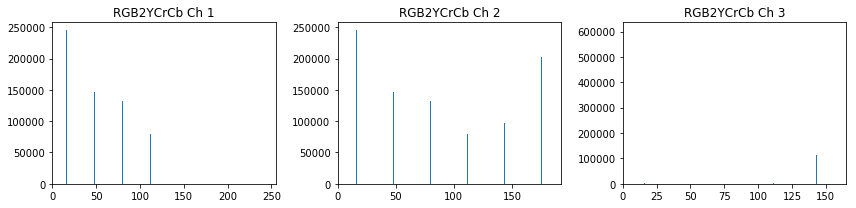

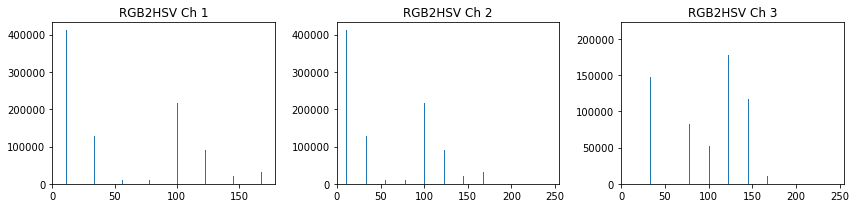

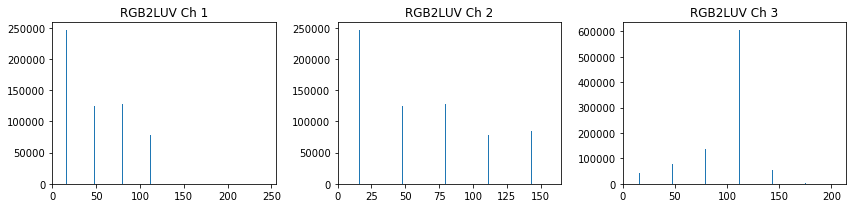

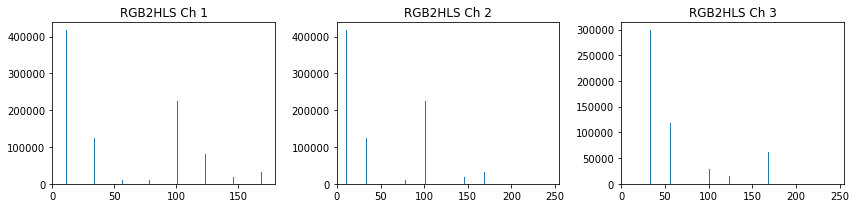

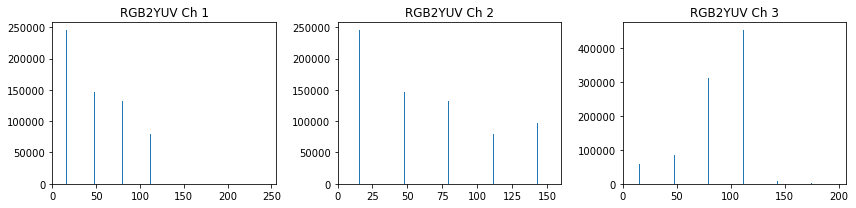

In [14]:
def plot_histograms(plots):
    for index, plot in enumerate(plots):
        ch1, ch2, ch3, bincen, feature_vec = plot
        
        fig = plt.figure(figsize=(12,3))
        
        space = color_spaces[index]
        
        plt.subplot(131)
        plt.bar(bincen, ch1[0])
        plt.xlim(0, max(ch1[1]))
        plt.title(space + ' Ch 1')
        
        plt.subplot(132)
        plt.bar(bincen, ch1[0])
        plt.xlim(0, max(ch2[1]))
        plt.title(space + ' Ch 2')
        
        plt.subplot(133)
        plt.bar(bincen, ch3[0])
        plt.xlim(0, max(ch3[1]))
        plt.title(space + ' Ch 3')
        
        fig.tight_layout()
    plt.show()
        
plot_histograms(test_histograms)

### Spatial Binning

In [15]:
def bin_spatial(image, color_spaces, size=(32, 32)):
    
    spatials = []
    
    for space in color_spaces:
        img = convert_color(np.copy(image), space)
    
        # Use cv2.resize().ravel() to create the feature vector
        resized = cv2.resize(img, size)
        spatial_features = resized.ravel()
        spatials.append(spatial_features)
    # Return the feature vector
    return spatials
    
spatial_feature_vecs = bin_spatial(test_images[4], color_spaces, size=(16, 16))

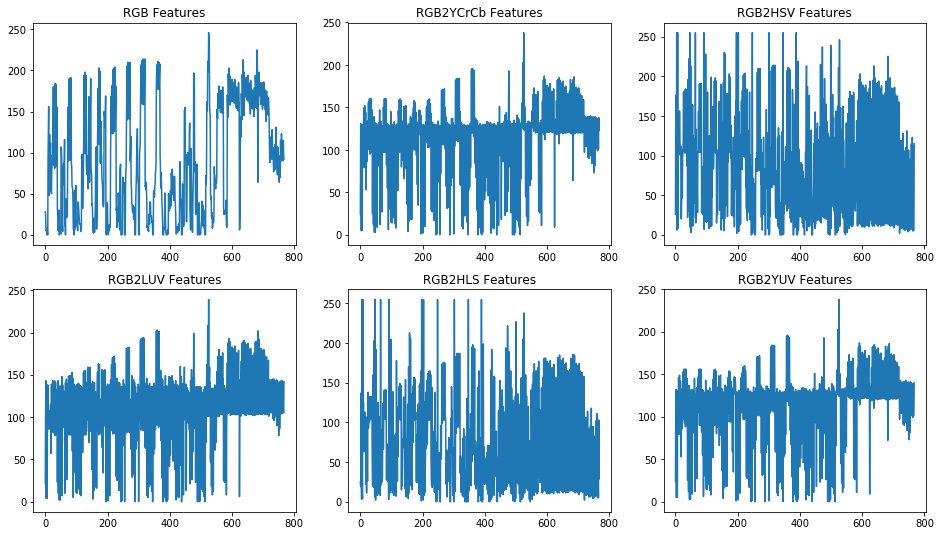

In [16]:
def plot_spatial_bins(vectors):
    
    fig = plt.figure(figsize=(16,9))
    
    columns = 3
    rows = round(len(vectors)/columns)
    
    for index, feature_vec in enumerate(vectors):
        a = fig.add_subplot(rows,columns,index+1)
        plt.title(color_spaces[index] + ' Features')
        plt.plot(feature_vec)
    plt.show()
    
plot_spatial_bins(spatial_feature_vecs)

### Histogram Oriented Gradients

In [160]:
# Define a function to return HOG features and visualization
def hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Define HOG parameters
TEST_ORIENT = 12
TEST_PIX_PER_CELL = 8
TEST_CELL_PER_BLOCK = 2

# Read in the image
test_hog_img = mpimg.imread('hog_test_2.png')

# Call our function with vis=True to see an image output
def test_hogs(image):
    hog_imgs = []
    
    for space in color_spaces:
        img = convert_color(np.copy(image), space)
        features, hog_image1 = hog_features(img[:,:,0], 
                                               TEST_ORIENT, TEST_PIX_PER_CELL, TEST_CELL_PER_BLOCK, 
                                               vis=True, feature_vec=False)
        features, hog_image2 = hog_features(img[:,:,1], 
                                               TEST_ORIENT, TEST_PIX_PER_CELL, TEST_CELL_PER_BLOCK, 
                                               vis=True, feature_vec=False)
        features, hog_image3 = hog_features(img[:,:,2], 
                                               TEST_ORIENT, TEST_PIX_PER_CELL, TEST_CELL_PER_BLOCK, 
                                               vis=True, feature_vec=False)
        
        hog_imgs.append(hog_image1); hog_imgs.append(hog_image2); hog_imgs.append(hog_image3);
    
    return hog_imgs

hog_images = test_hogs(test_hog_img)


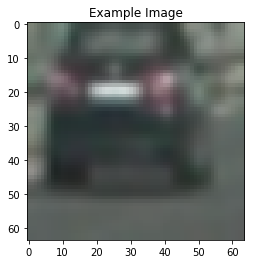

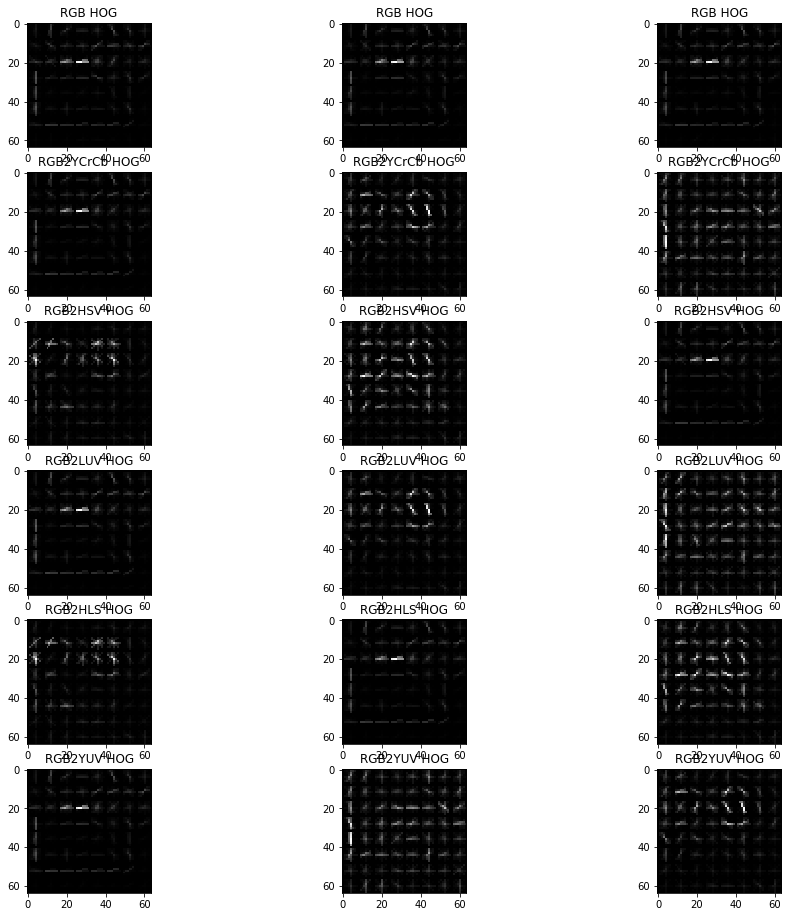

In [161]:
def plot_hog_features(hogs):
    plt.imshow(test_hog_img)
    plt.title('Example Image')
    plt.show()
    
    fig = plt.figure(figsize=(16,16))
    
    columns = 3
    rows = round(len(hogs)/columns)
    
    for index, hog_img in enumerate(hogs):
        a = fig.add_subplot(rows,columns,index+1)
        plt.title(color_spaces[index//3] + ' HOG')
        plt.imshow(hog_img, cmap='gray')
    plt.show()
    
plot_hog_features(hog_images)

**Requirement: Explain how (and identify where in your code) you extracted HOG features from the training images.**

**Requirement: Explain how you settled on your final choice of HOG parameters.**

### Import Data Set

Cars: 8792
Not Cars: 8968
Total images:17760
Image shape: (64, 64, 3)
Data type: <class 'numpy.ndarray'>


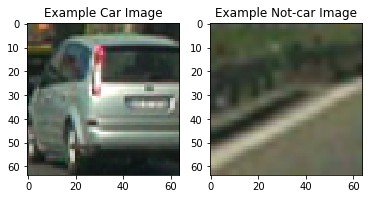

In [19]:
# Import Car and Non-car data

cars = glob.glob('datasets/vehicles/**/*.png', recursive=True)
notcars = glob.glob('datasets/non-vehicles/**/*.png', recursive=True)

example = mpimg.imread(cars[0])

print('Cars: ' + str(len(cars)))
print('Not Cars: ' + str(len(notcars)))
print('Total images:' + str(len(cars) + len(notcars)))
print('Image shape: ' + str(example.shape))
print('Data type: ' + str(type(example)))

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()

plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')

plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

plt.show()

### Feature Normalization Step

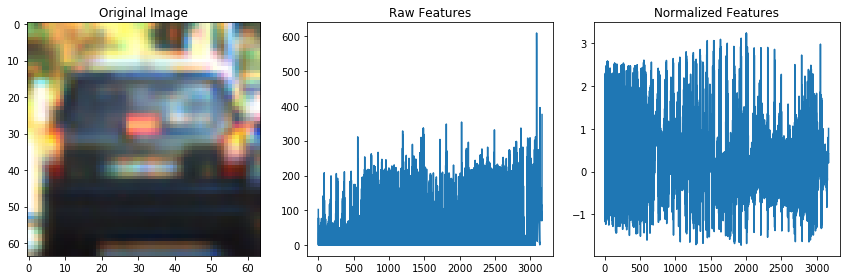

In [20]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    
    for img in imgs:
        image = mpimg.imread(img)
        
        # TODO: Handle color space conversions
        image = convert_color(image, cspace)
        
        bin_feats = bin_spatial(image)
        hist_feats = color_hist(image, nbins=32)
        features.append(np.concatenate((bin_feats, hist_feats)))
    # Return list of feature vectors
    return features
        
norm_car_features = extract_features(cars, cspace='RGB2HSV', spatial_size=(16, 16), hist_bins=8)

norm_notcar_features = extract_features(notcars, cspace='RGB2HSV', spatial_size=(16, 16), hist_bins=8)

norm_scaled_X = None

if len(norm_car_features) > 0:
    # Create an array stack of feature vectors
    X_norm = np.vstack((norm_car_features, norm_notcar_features)).astype(np.float64)                        
    
    # Fit a per-column scaler
    X_scaler_norm = StandardScaler().fit(X_norm)
    
    # Apply the scaler to X
    norm_scaled_X = X_scaler_norm.transform(X_norm)
    car_ind = np.random.randint(0, len(cars))
    
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    
    plt.subplot(132)
    plt.plot(X_norm[car_ind])
    plt.title('Raw Features')
    
    plt.subplot(133)
    plt.plot(norm_scaled_X[car_ind])
    plt.title('Normalized Features')
    
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

### Train Classifier

**Requirement: Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).**

### Color Classify

In [21]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, cspace)
            
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

# Subsample Dataset for this classification
color_sample_size = 500
color_cars = cars[0:color_sample_size]
color_notcars = notcars[0:color_sample_size]

# TODO play with these values to see how your classifier
# performs under different binning scenarios
color_spatial = 16
color_histbin = 8

color_car_features = extract_features(color_cars, cspace='RGB2HLS', 
                                      spatial_size=(color_spatial, color_spatial),
                                      hist_bins=color_histbin)
color_notcar_features = extract_features(color_notcars, cspace='RGB2HLS',
                                         spatial_size=(color_spatial, color_spatial),
                                         hist_bins=color_histbin)

In [22]:
# Create an array stack of feature vectors
X_color = np.vstack((color_car_features, color_notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_color_scaler = StandardScaler().fit(X_color)

# Apply the scaler to X
color_scaled_X = X_color_scaler.transform(X_color)

# Define the labels vector
y_color = np.hstack((np.ones(len(color_car_features)), np.zeros(len(color_notcar_features))))

# Split up data into randomized training and test sets
color_rand_state = np.random.randint(0, 100)
X_train_color, X_test_color, y_train_color, y_test_color = train_test_split(color_scaled_X, y_color, test_size=0.2, random_state=color_rand_state)

print('Using spatial binning of:',color_spatial,'and', color_histbin,'histogram bins')
print('Feature vector length:', len(X_train_color[0]))

# Use a linear SVC 
color_svc = svm.SVC()

# Optimize
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
color_svc = GridSearchCV(color_svc, parameters)

# Check the training time for the SVC
t=time.time()
color_svc.fit(X_train_color, y_train_color)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(color_svc.score(X_test_color, y_test_color), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', color_svc.predict(X_test_color[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test_color[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 16 and 8 histogram bins
Feature vector length: 792
2.47 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  0.  0.  1.  1.  0.]
0.00511 Seconds to predict 10 labels with SVC


### HOG Classify

In [23]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_hog_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        
        feature_image = convert_color(image, cspace)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
hog_sample_size = 500
hog_cars = cars[0:hog_sample_size]
hog_notcars = notcars[0:hog_sample_size]

### TODO: Tweak these parameters and see how the results change.
HOG_COLOR_SPACE = 'RGB2HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
HOG_ORIENT = 9
HOG_PIX_PER_CELL = 8
HOG_CELL_PER_BLOCK = 2
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
hog_car_features = extract_hog_features(hog_cars, 
                                        cspace = HOG_COLOR_SPACE, 
                                        orient = HOG_ORIENT, 
                                        pix_per_cell = HOG_PIX_PER_CELL, 
                                        cell_per_block = HOG_CELL_PER_BLOCK, 
                                        hog_channel = HOG_CHANNEL)
hog_notcar_features = extract_hog_features(hog_notcars, 
                                           cspace = HOG_COLOR_SPACE, 
                                           orient = HOG_ORIENT, 
                                           pix_per_cell = HOG_PIX_PER_CELL, 
                                           cell_per_block = HOG_CELL_PER_BLOCK, 
                                           hog_channel = HOG_CHANNEL)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X_hog = np.vstack((hog_car_features, hog_notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler_hog = StandardScaler().fit(X_hog)

# Apply the scaler to X
hog_scaled_X = X_scaler_hog.transform(X_hog)

# Define the labels vector
y_hog = np.hstack((np.ones(len(hog_car_features)), np.zeros(len(hog_notcar_features))))

# Split up data into randomized training and test sets
hog_rand_state = np.random.randint(0, 100)
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(hog_scaled_X, y_hog, test_size=0.2, random_state=hog_rand_state)

print('Using:',HOG_ORIENT,'orientations',HOG_PIX_PER_CELL,
    'pixels per cell and', HOG_CELL_PER_BLOCK,'cells per block')
print('Feature vector length:', len(X_train_hog[0]))

# Use a linear SVC 
hog_svc = svm.SVC()

# Check the training time for the SVC
t=time.time()
hog_svc.fit(X_train_hog, y_train_hog)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(hog_svc.score(X_test_hog, y_test_hog), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', hog_svc.predict(X_test_hog[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test_hog[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

81.69 Seconds to extract HOG features...
Using: 9 orientations 2 pixels per cell and 2 cells per block
Feature vector length: 103788
67.76 Seconds to train SVC...
Test Accuracy of SVC =  0.985
My SVC predicts:  [ 1.  0.  0.  1.  0.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  0.  1.  0.  0.  1.]
0.78453 Seconds to predict 10 labels with SVC


## Sliding Window Search

**Requirement: Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?**

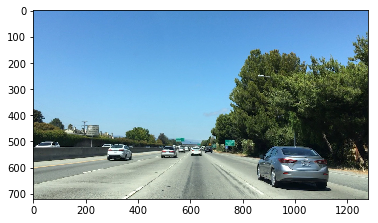

In [24]:
bbox_img = cv2.imread('bbox-example-image.jpg')
bbox_img = cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB)

plt.imshow(bbox_img)
plt.show()

436 windows created


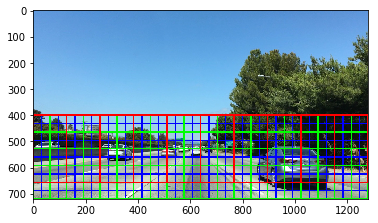

In [25]:

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
        
    # Return the list of windows
    return window_list

x_start = 0
x_stop = bbox_img.shape[1]

y_start = 400
y_stop = bbox_img.shape[0]

small_window = (64,64)
medium_window = (128, 128)
large_window = (256, 256)

window_sizes = [small_window, medium_window, large_window]
colors = [(0,0,255), (0,255,0), (255,0,0)]

window_img = np.copy(bbox_img)

window_count = 0
for index, size in enumerate(window_sizes):
    windows = slide_window(window_img, x_start_stop=[x_start, x_stop], y_start_stop=[y_start, y_stop], 
                            xy_window=size, xy_overlap=(0.5, 0.5))
    window_img = draw_boxes(window_img, windows, color=colors[index], thick=3)
    
    window_count += len(windows)

print(str(window_count) + ' windows created')
plt.imshow(window_img)
plt.show()

### Combine Methods

In [162]:
COLOR_CSPACE = 'RGB2LUV'
HOG_CSPACE = 'RGB2HSV'
FINAL_ORIENT = 12
FINAL_PIX_PER_CELL = 8
FINAL_CELL_PER_BLOCK = 2
FINAL_SPATIAL_SIZE = (16, 16)
FINAL_HIST_BINS = 8

ystart = 400
ystop = 656
SM_SCALE = 1.0
MED_SCALE = 2.0
LG_SCALE = 2.5

In [142]:

def find_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def find_bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def find_color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [163]:
def get_features(files):
    combo = []
    for file in files:
        img = mpimg.imread(file)
        combo.append(extract_combined_features(img, COLOR_CSPACE, HOG_CSPACE))
    return combo

def extract_combined_features(img, color_cspace, hog_cspace):
        
    # Apply color conversion if other than 'RGB'
    color_feature_image = convert_color(img, color_cspace)
    hog_feature_image = convert_color(img, hog_cspace)
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = find_bin_spatial(color_feature_image, size=FINAL_SPATIAL_SIZE)

    # Apply color_hist() also with a color space option now
    hist_features = find_color_hist(color_feature_image, nbins=FINAL_HIST_BINS)

    # Append the new feature vector to the features list    
    
    hog_feat1 = get_hog_features(hog_feature_image[:,:,0], FINAL_ORIENT, FINAL_PIX_PER_CELL, FINAL_CELL_PER_BLOCK)
    hog_feat2 = get_hog_features(hog_feature_image[:,:,1], FINAL_ORIENT, FINAL_PIX_PER_CELL, FINAL_CELL_PER_BLOCK)
    hog_feat3 = get_hog_features(hog_feature_image[:,:,2], FINAL_ORIENT, FINAL_PIX_PER_CELL, FINAL_CELL_PER_BLOCK)
    hogs_feats = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        
    return np.hstack((spatial_features, hist_features, hogs_feats))

In [164]:
tester = extract_combined_features(test_images[3], COLOR_CSPACE, HOG_CSPACE)

### Train Detection Classifier

In [165]:
car_feats = get_features(cars)
noncar_feats = get_features(notcars)

# Create an array stack of feature vectors
X = np.concatenate((car_feats, noncar_feats)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_feats)), np.zeros(len(noncar_feats))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',FINAL_SPATIAL_SIZE,'and', FINAL_HIST_BINS,'histogram bins')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = svm.SVC()

# Optimize
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = GridSearchCV(svc, parameters)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: (16, 16) and 8 histogram bins
Feature vector length: 7848
105.83 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  1.]
For these 20 labels:  [ 0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  1.]
0.05005 Seconds to predict 20 labels with SVC


### Find Cars

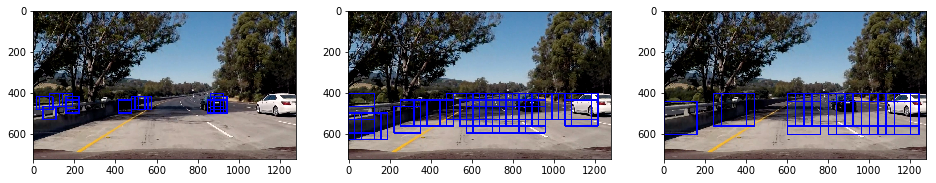

In [171]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """ Extract features using hog sub-samp
    ling and make predictions."""
    
    # Preserve full image to draw rectangles over
    draw_img = np.copy(img)
    
    """
    Set image value range of 0 to 1 to match those of images used while training the model.
    Data set images are PNG vs. test images/video frames which are JPEG 
    """ 
    img = img.astype(np.float32)/255
    
    # Set vehicle detection region of interest
    img_tosearch = img[ystart:ystop,:,:]
    
    # Convert image to desired color space
    ctrans_tosearch = convert_color(img_tosearch, HOG_CSPACE)
    color_trans = convert_color(img_tosearch, COLOR_CSPACE)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # HOG Color channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = find_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = find_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = find_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # A list to store all the windows where vehicles are detected
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(color_trans[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = find_bin_spatial(subimg, size=spatial_size)
            hist_features = find_color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, car_windows

track_example = np.copy(test_images[4])

scale1_img, scale1_windows = find_cars(track_example, ystart, ystop, SM_SCALE, svc, X_scaler, FINAL_ORIENT, FINAL_PIX_PER_CELL, FINAL_CELL_PER_BLOCK, FINAL_SPATIAL_SIZE, FINAL_HIST_BINS)
scale2_img, scale2_windows = find_cars(track_example, ystart, ystop, MED_SCALE, svc, X_scaler, FINAL_ORIENT, FINAL_PIX_PER_CELL, FINAL_CELL_PER_BLOCK, FINAL_SPATIAL_SIZE, FINAL_HIST_BINS)
scale3_img, scale3_windows = find_cars(track_example, ystart, ystop, LG_SCALE, svc, X_scaler, FINAL_ORIENT, FINAL_PIX_PER_CELL, FINAL_CELL_PER_BLOCK, FINAL_SPATIAL_SIZE, FINAL_HIST_BINS)

plot_grid([scale1_img, scale2_img, scale3_img])
# plt.imshow(scale1_img)
# plt.show()

### Multiple Detections & False Positives

**Requirement: Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.**

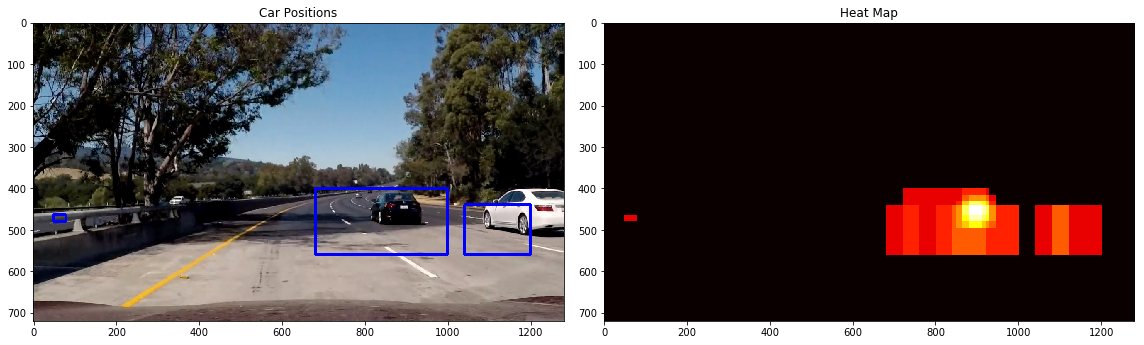

In [176]:
DETECTION_THRESHOLD = 3

# Get all boxes detected by sliding windows search
box_list = scale1_windows  + scale3_windows

# Read in image similar to one shown above 
multi_detection_image = np.copy(test_images[4]) #mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(multi_detection_image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold=DETECTION_THRESHOLD):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
    
# Add heat to each box in box list
heat = add_heat(heat,box_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,DETECTION_THRESHOLD)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(multi_detection_image), labels)

fig = plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

plt.show()

### Process Frame

In [177]:
def highlight_cars(image, windows):
    
    hot = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    hot = add_heat(hot, windows)

    # Apply threshold to help remove false positives
    hot = apply_threshold(hot)

    # Visualize the heatmap when displaying    
    heat_map = np.clip(hot, 0, 255)

    # Find final boxes from heatmap using label function
    heat_labels = label(heat_map)
    highlight_image = draw_labeled_bboxes(np.copy(image), heat_labels)
    return highlight_image

def process_frame(frame):
    sm_img, sm_windows = find_cars(frame, ystart, ystop, SM_SCALE, svc, X_scaler, FINAL_ORIENT, FINAL_PIX_PER_CELL, FINAL_CELL_PER_BLOCK, FINAL_SPATIAL_SIZE, FINAL_HIST_BINS)
#     med_img, med_windows = find_cars(frame, ystart, ystop, MED_SCALE, svc, X_scaler, FINAL_ORIENT, FINAL_PIX_PER_CELL, FINAL_CELL_PER_BLOCK, FINAL_SPATIAL_SIZE, FINAL_HIST_BINS)
    lg_img, lg_windows = find_cars(frame, ystart, ystop, LG_SCALE, svc, X_scaler, FINAL_ORIENT, FINAL_PIX_PER_CELL, FINAL_CELL_PER_BLOCK, FINAL_SPATIAL_SIZE, FINAL_HIST_BINS)

    all_windows = sm_windows + lg_windows #+ med_windows + lg_windows
    
    return highlight_cars(frame, all_windows)

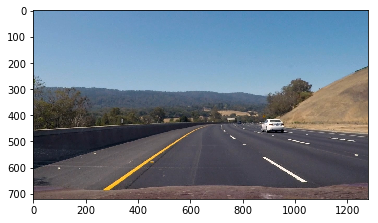

In [178]:
plt.imshow(process_frame(test_images[2]))
plt.show()

**Requirement: Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?**

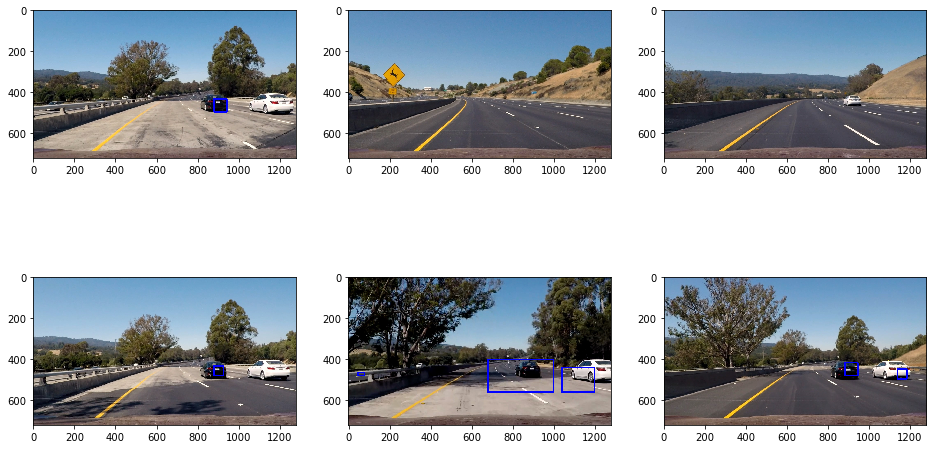

In [179]:
def scan_test_images(images):
    scans = []
    
    for img in images:
        scans.append(process_frame(img))
    return scans

plot_grid(scan_test_images(test_images))

## Video Implementation

**Requirement: Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)**

### Process Video

In [180]:
def process_video(input_path, output_path):
    clip  = VideoFileClip(input_path)

    new_frames = []
        
    for frame in clip.iter_frames():
        new_frames.append(process_frame(frame))
    
    new_clip = ImageSequenceClip(new_frames, fps=clip.fps)
    new_clip.write_videofile(output_path, audio=False)
    
    HTML("""
    <video width="1280" height="720" controls>
      <source src="{0}">
    </video>
    """.format(output_path))

### Test Video

In [181]:
test_input = "test_video.mp4"
test_output = "output_images/video_test.mp4"

process_video(test_input, test_output)

[MoviePy] >>>> Building video output_images/video_test.mp4
[MoviePy] Writing video output_images/video_test.mp4


100%|██████████| 39/39 [00:00<00:00, 117.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_test.mp4 



### Project Video

In [ ]:
project_input = "project_video.mp4"
project_output = "output_images/video_project.mp4"

process_video(project_input, project_output)

## Discussion

**Requirement: Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?**